In [26]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tqdm
import os
import numpy as np

In [62]:
df = pd.read_csv("./frame_anno1_anno2.csv", names=["frame", "anno1", "anno2"])
glove = []
for index, row in df.iterrows():
    frame = row['frame']
    name = os.path.basename(frame)
    glove.append(int("GL" in name))

df["GL"] = glove
print(len(df[df["GL"] == 1]))
print(len(df[df["GL"] == 0]))
df

1172
155


,frame,anno1,anno2,GL
0,Sampled_Frames/Test_Subject_9/id/Jenga_task/To...,Annotations/Test_Subject_9/By_1/id/Jenga_task/...,Annotations/Test_Subject_9/By_2/id/Jenga_task/...,1
1,Sampled_Frames/Test_Subject_4/id/Jenga_task/Si...,Annotations/Test_Subject_4/By_1/id/Jenga_task/...,Annotations/Test_Subject_4/By_2/id/Jenga_task/...,1
2,Sampled_Frames/Test_Subject_1/id/Jenga_task/Si...,Annotations/Test_Subject_1/By_1/id/Jenga_task/...,Annotations/Test_Subject_1/By_2/id/Jenga_task/...,1
3,Sampled_Frames/Test_Subject_1/id/Jenga_task/Si...,Annotations/Test_Subject_1/By_1/id/Jenga_task/...,Annotations/Test_Subject_1/By_2/id/Jenga_task/...,1
4,Sampled_Frames/Test_Subject_1/id/Jenga_task/Si...,Annotations/Test_Subject_1/By_1/id/Jenga_task/...,Annotations/Test_Subject_1/By_2/id/Jenga_task/...,1
...,...,...,...,...
1322,Sampled_Frames/Test_Subject_9/ood/Toolbox_task...,Annotations/Test_Subject_9/By_1/ood/Toolbox_ta...,Annotations/Test_Subject_9/By_2/ood/Toolbox_ta...,1
1323,Sampled_Frames/Test_Subject_9/ood/Toolbox_task...,Annotations/Test_Subject_9/By_1/ood/Toolbox_ta...,Annotations/Test_Subject_9/By_2/ood/Toolbox_ta...,0
1324,Sampled_Frames/Test_Subject_9/ood/Toolbox_task...,Annotations/Test_Subject_9/By_1/ood/Toolbox_ta...,Annotations/Test_Subject_9/By_2/ood/Toolbox_ta...,0
1325,Sampled_Frames/Test_Subject_9/ood/Toolbox_task...,Annotations/Test_Subject_9/By_1/ood/Toolbox_ta...,Annotations/Test_Subject_9/By_2/ood/Toolbox_ta...,0


1


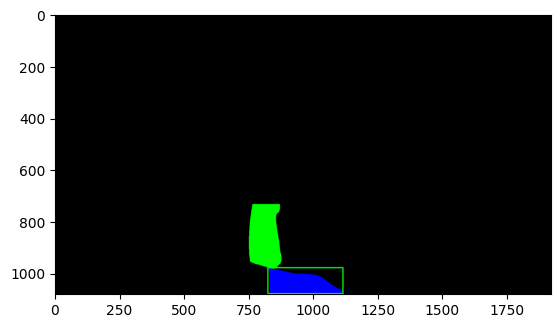

In [53]:
def draw(frame_path, coords):
    frame = cv2.imread(frame_path)
    H, W = frame.shape[:2]
    new_coords = []
    is_hand = (0, 255, 0) if "GL" in frame_path else (0, 0 , 255)
    print(len(coords))
    for xc, yc, w, h in coords:
        w = w * W
        h = h * H

        xc = xc * W
        yc = yc * H

        x1 = int(xc - w / 2)
        y1 = int(yc - h / 2)

        x2 = int(x1 + w) 
        y2 = int(y1 + h) 


        cv2.rectangle(frame, (x1, y1), (x2, y2), is_hand, 3)
    
    plt.imshow(frame[:, :, ::-1])

draw("Annotations/Test_Subject_1/By_1/id/Jenga_task/Side_View/Jenga_GL_3374.0.png", [(0.5036458333333333, 0.9518518518518518, 0.15104166666666666, 0.09259259259259259)])

[(0.50390625, 0.9527777777777777, 0.1515625, 0.09444444444444444), (0.42291666666666666, 0.7944444444444444, 0.065625, 0.23148148148148148)]
2


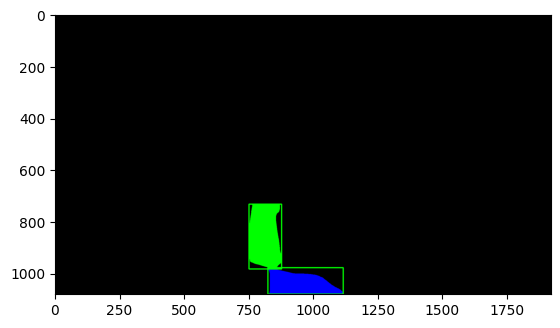

In [54]:
def get_coords(frame_path):
    frame = cv2.imread(frame_path)
    H, W = frame.shape[:2]
    objs = []
    for i in [0, 1]:
        gray_image = np.squeeze(frame[:, :, i].copy())
        # Apply Gaussian blur to reduce noise
        blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

        # Threshold the image to convert it to a binary image
        _, binary_image = cv2.threshold(blurred_image, 100, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            x = (x + w/2) / W
            y = (y + h/2) / H
            w = w/W
            h = h/H
            if w*h < 0.001: continue
            objs.append((x, y, w, h))

    return objs
    # Draw contours on the original image
    # contour_image = np.copy(frame)
    # draw = cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    # plt.imshow(draw)
    # plt.show()
    
frame_path = "Annotations/Test_Subject_1/By_1/id/Jenga_task/Side_View/Jenga_GL_3374.0.png"
coords = get_coords(frame_path)
print(coords)
draw(frame_path, coords)


In [57]:
import shutil

for index, row in tqdm.tqdm(df.iterrows()):
    frame_path = row["frame"]
    filename = os.path.basename(frame_path)
    shutil.copyfile(frame_path, "data/images/"+filename)

1328it [01:31, 14.52it/s]


In [63]:
for index, row in tqdm.tqdm(df.iterrows()):
    frame_path = row["anno1"]
    label = row["GL"]

    name = os.path.basename(frame_path)
    label_name = name[:-3] + "txt"
    label_path = f"data/labels/{label_name}"

    coords = get_coords(frame_path)
    # draw(frame_path, coords)
    with open(label_path, "w+") as f:
        for x,y,w,h in coords:
            line = f"{label} {x} {y} {w} {h}\n"
            f.write(line)


1327it [00:44, 30.00it/s]


In [67]:
import random
image_names = os.listdir("./data/images")
names = [iname[:-4] for iname in image_names if len(iname) > 5]

random.shuffle(names)
n = len(names)
len_p1 = int(n * 0.8)
len_p2 = int(n * 0.9)

dataset = {
"train": names[:len_p1],
"val": names[len_p1 : len_p2],
"test": names[len_p2 :]
    
}

for key, names in dataset.items():
    for name in tqdm.tqdm(names):
        img_path = f"./data/images/{name}.png"
        label_path = f"./data/labels/{name}.txt"

        shutil.move(img_path, f"data/images/{key}/{name}.png")
        shutil.move(label_path, f"data/labels/{key}/{name}.txt")

  0%|          | 0/1061 [00:00<?, ?it/s]

100%|██████████| 133/133 [00:00<00:00, 436.76it/s]


In [44]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml').load('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 7.59MB/s]

Transferred 355/355 items from pretrained weights
